In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *
import os

In [81]:
new_output='/global/homes/v/vboehm/codes/postborn-corrections/scripts/los/output/lsst-all-simple/'

In [77]:
##general settings
LSST      = True
#if not LSST redhsift kernel
z0        = 1.
sigma_z   = 0.1
bin_num   = 'all'
bias      = 'simple'
z_source  = z_cmb
zmax      = z_source
chimax    = chi_z(zmax)
s         = 0.6
print('zmax=%d'%zmax, 'chimax=%d'%chimax)

if z_source==z_cmb:
    chi_source = chi_cmb
else:
    chi_source = chi_z(z_source)

if LSST:
    if chi_source==chi_cmb:
        file_ext = 'lsst%s_cmblens_'%str(bin_num)
    else:
        file_ext = 'lsst%s_deltalens_z%d_'%(str(bin_num),z_source*10)
else:
    if chi_source==chi_cmb:
        file_ext = 'gaussgal_z%d_sigma%d_cmblens_'%(z0*10,sigma_z*10)
    else:
        file_ext = 'gaussgal_z%d_sigma%d_deltalens_z%d_'%(z0*10,sigma_z*10,z_source*10) 
    
file_ext+=bias+'_bias'

file_ext+=  '_zmax%d'%(zmax*10)
file_ext2 = 'zmax%d'%(zmax*10)
    
print(file_ext, file_ext2)


if bias == 'simple':
    bias_func = simple_bias
elif bias =='constant':
    bias_func = constant_bias
else:
    print('no valid bias function selected')



params = {}
params['LSST'] = LSST
params['z0'] = z0
params['sigma_z'] = sigma_z
params['bin_num'] = bin_num
params['chimax'] = chimax
params['chisource'] = chi_source
params['zsource'] = z_source
params['ext'] = file_ext
params['ext2']= file_ext2
params['s'] = s
params['bias']=bias

try: 
    params_ = pickle.load(open('../settings/params_%s.pkl'%file_ext,'rb'))
    assert(params==params_)
except:
    pickle.dump(params,open('../settings/params_%s.pkl'%file_ext,'wb'))



zmax=1088 chimax=9414
lsstall_cmblens_simple_bias_zmax10886 zmax10886


In [78]:
plotpath = '../plots/%s/'%file_ext
if os.path.isdir(plotpath):
    print('plot path exists')
else:
    os.mkdir(plotpath)

plot path exists


In [79]:
print('delta lensing with chimax %d'%chimax)
def lensing_kernel(xi):
    xmax = chi_source
    return (xmax - xi)/(xmax*xi) * (xmax > xi)
    
if LSST:
    if bin_num == 'all':
        def galax_kernel(x):
            return lsst_kernel_cb(x)*simple_bias(x)
    else:
        def galax_kernel(x):
            return lsst_kernel_cbn[bin_num](x)*simple_bias(x)
else:
    kernel = gal_clus(Gauss_redshift(sigma_z=sigma_z,z0=z0), bias_func)
    def galax_kernel(x):
        return kernel(x)
    
print(galax_kernel(chimax))

delta lensing with chimax 9414
0.0


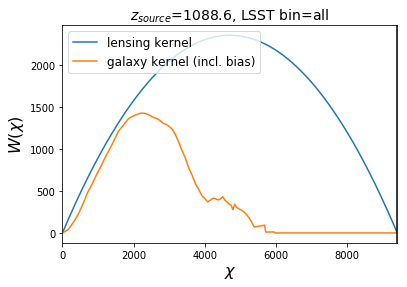

In [43]:
#see if kernels are sensible
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=14)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=14)   
chis = np.linspace(1,chimax,20000)
plt.plot(chis, lensing_kernel(chis)*chis**2,label='lensing kernel')
plt.plot(chis, galax_kernel(chis)*2e6, label='galaxy kernel (incl. bias)')
plt.axvline(x=chimax,color='black')
plt.xlabel('$\chi$',fontsize=16)
plt.ylabel('$W(\chi)$',fontsize=16)
plt.legend(loc='upper left',fontsize=12)
plt.xlim(0,chimax)
plt.savefig(plotpath+'redshiftkernels_%s.png'%file_ext, bbox_inches='tight',dpi=400)

In [44]:
#only integrates to one for constant bias!
np.trapz(chis,galax_kernel(chis))

-2.0540870618297493

In [45]:
L = np.logspace(np.log10(min(ell_)),np.log10(1000),100)
l = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),500)

### computing auto and cross spectra first

In [46]:
# clkg
try:
    ell_,Cl_kg= np.load('../output/cls/Clkg_%s.npy'%(file_ext))
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    # chimax and kernels

    kernel1  = lensing_kernel
    kernel2  = galax_kernel

    n = 2

    begin=time.time()

    chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
    chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

    chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
    chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
    chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = w11*w12*chi1fac0* chi2fac0

    result=np.zeros_like(ell_)
    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I2_ltrc[ii])


    Cl_pg = chimax * result*1./np.pi**2/2.*prefac/4.*2

    print('Time taken = ', time.time()-begin)

    Cl_kg = 1./2*(ell_*(ell_+1.))*Cl_pg

    np.save('../output/cls/Clkg_%s.npy'%(file_ext),[ell_,Cl_kg])

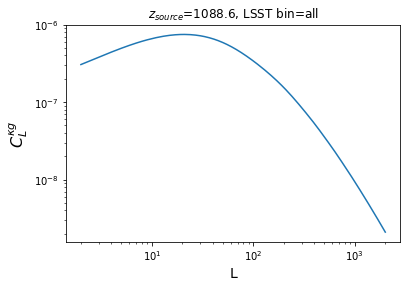

In [47]:
plt.figure()
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=12)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=12)    
plt.ylabel(r'$C_L^{\kappa g}$', fontsize=16)
plt.xlabel('L', fontsize=14)
p=plt.loglog(ell_,Cl_kg)
plt.loglog(ell_,-Cl_kg,c=p[0].get_color(),ls='--')
plt.savefig(plotpath+'clkg_%s.pdf'%file_ext, bbox_inches='tight')
plt.show()

In [48]:
#clkk
try:
    ell_,Cl_kk=np.load('../output/cls/Clkk_%s.npy'%(file_ext))
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    # inflate by one dimensions (nu_n)
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    n=0

    begin=time.time()

    chi1fac0 = (lensing_kernel(r2d*chimax)*(1+z_chi(r2d*chimax))*D_chi(r2d*chimax))
    chi1fac0 = chi1fac0 *(r2d*chimax)**(1-nu_n_.reshape(1, 1, -1))

    chi2fac00 = (lensing_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*(1+z_chi(r2d*t2d*chimax)))
    chi2fac01 = (lensing_kernel(1./t2d*r2d*chimax)*D_chi(r2d*1./t2d*chimax)*(1+z_chi(r2d/t2d*chimax)))
    chi2fac01 = chi2fac01 * t2d**(n+nu_n_.reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = w11*w12*chi1fac0* chi2fac0

    result=np.zeros_like(ell_)
    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I0_ltrc[ii])

    Clpp  = 2**2*chimax * result*1./np.pi**2/2.*prefac**2/4. #factor 2 for every phi = -2 int W psi
    #factor of 1/2 for every gaussian quadrature

    Cl_kk = 1./4*(ell_*(ell_+1.))**2*Clpp

    np.save('../output/cls/Clkk_%s.npy'%(file_ext),[ell_,Cl_kk])

    print('Time taken = ', time.time()-begin)

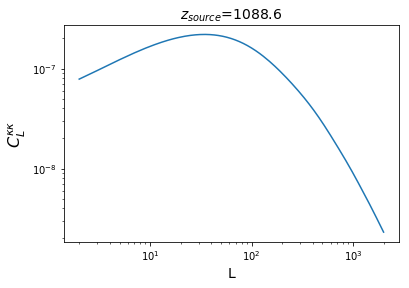

In [49]:
plt.figure()
plt.title('$z_{source}$=%.1f'%(z_source),fontsize=14)
plt.ylabel(r'$C_L^{\kappa \kappa}$', fontsize=16)
plt.xlabel('L', fontsize=14)
p=plt.loglog(ell_,Cl_kk)
plt.loglog(ell_,-Cl_kk,c=p[0].get_color(),ls='--')
plt.savefig(plotpath+'clkk_%s.pdf'%file_ext, bbox_inches='tight')
plt.show()

In [50]:
#clgg
try:
    ell_,Cl_gg = np.load('../output/cls/Clgg_%s.npy'%(file_ext))
except:    
    begin=time.time()

    n = 4
    chi1fac0 = (galax_kernel(r2d*chimax)*D_chi(r2d*chimax))
    chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

    chi2fac00 = (galax_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
    chi2fac01 = (galax_kernel(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax))
    chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = w11*w12*chi1fac0* chi2fac0

    result=np.zeros_like(ell_)
    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I4_ltrc[ii])

    Cl_gg = chimax * result/np.pi**2/2./4. #dividing by extra factor of 4 (should be there because of Gaussian Quadrature)

    np.save('../output/cls/Clgg_%s.npy'%(file_ext),[ell_,Cl_gg])

    print('Time taken = ', time.time()-begin)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.7325725555419922


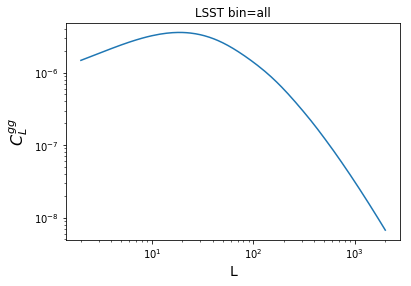

In [51]:
plt.figure()
if LSST:
    plt.title('LSST bin=%s'%(str(bin_num)),fontsize=12)
else:
    plt.title('$z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z0, sigma_z),fontsize=12)   
plt.ylabel(r'$C_L^{gg}$', fontsize=16)
plt.xlabel('L', fontsize=14)
p=plt.loglog(ell_,Cl_gg)
plt.loglog(ell_,-Cl_gg,c=p[0].get_color(),ls='--')
plt.savefig(plotpath+'Clgg_%s.pdf'%file_ext, bbox_inches='tight')
plt.show()

### Magnification Bias

In [53]:
try:
    ell_,J11bare = np.load('../output/cls/ClkgJacobianbare_%s.npy'%(file_ext))
except:
    clphiphi_xi_xi_source = np.load('../G_matrices/clphiphi_parallel_chisource_%s.npy'%file_ext)
    kernel1 = galax_kernel
    result = np.zeros_like(ell_)
    for ii in range(len(ell_)):
        result[ii]= ell_[ii]**4*chimax*np.sum(w1*kernel1(t_*chimax)*clphiphi_xi_xi_source[ii])/2.
    J11bare = result
    np.save('../output/cls/ClkgJacobianbare_%s.npy'%(file_ext),[ell_,J11bare])

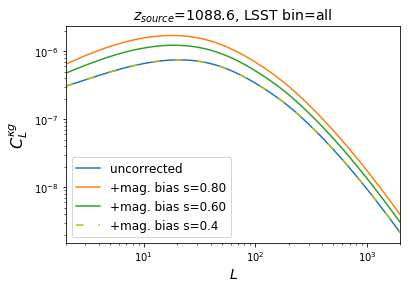

In [56]:
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=14)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=14)   
plt.loglog(ell_,Cl_kg,ls='-',label='uncorrected')
for s in [0.8,0.6]:
    p=plt.semilogx(ell_,J11bare*5.*(s-0.4)+Cl_kg,ls='-', label='+mag. bias s=%.2f'%s)
    plt.semilogx(ell_,-(J11bare*5.*(s-0.4)+Cl_kg),ls='--', c=p[0].get_color())
plt.loglog(ell_,Cl_kg,ls=(0,(5,10)), color='y',label='+mag. bias s=%.1f'%0.4)
plt.xlabel('$L$',fontsize=14)
plt.ylabel(r'$C_L^{\kappa g}$', fontsize=16)
plt.legend(loc='lower left',fontsize=12)
plt.xlim(min(ell_),max(ell_))
plt.savefig(plotpath+'clkg_magbias_%s.png'%file_ext, bbox_inches='tight',dpi=400)


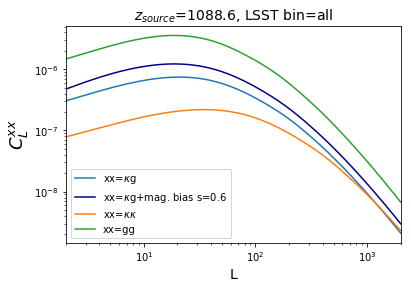

In [57]:
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=14)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=14)   
plt.loglog(ell_,Cl_kg,label='xx=$\kappa$g')
s=0.6
plt.semilogx(ell_,(J11bare*5.*(s-0.4)+Cl_kg),ls='-', c='darkblue',label='xx=$\kappa$g+mag. bias s=0.6')
plt.loglog(ell_,Cl_kk,label='xx=$\kappa\kappa$')
plt.loglog(ell_,Cl_gg,label='xx=gg')

plt.legend(fontsize=16)
plt.xlabel('L',fontsize=14)
plt.ylabel(r'$C_L^{xx}$', fontsize=18)
plt.legend()
plt.xlim(min(ell_),max(ell_))
plt.savefig(plotpath+'cls_%s.png'%file_ext, bbox_inches='tight',dpi=400)


### 1) Terms that are non-zero in Limber

In [60]:
#getting MA 22
chi1s, chi2s, clphiphirt = np.load('../G_matrices/clphiphi_rt_%s.npy'%file_ext2)
chi1s_, chi2s_, clphiphir_over_t = np.load('../G_matrices/clphiphi_r_over_t_%s.npy'%file_ext2)
clphiphirt = np.swapaxes(clphiphirt,1,2)
clphiphir_over_t = np.swapaxes(clphiphir_over_t,1,2)

try: 
    _, M22A = np.load('../M_matrices/M22A_%s.npy'%file_ext)
    M22A_spline = RectBivariateSpline(ell_,ell_,M22A)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    clphiphirt_ = np.expand_dims(clphiphirt,-1)
    clphiphir_over_t_ = np.expand_dims(clphiphir_over_t,-1)

    result = np.zeros((len(ell_),len(ell_)))

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = (lensing_kernel(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (galax_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*clphiphirt_[nn])
        chi2fac01 = (galax_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*clphiphir_over_t_[nn])
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M22A = chimax * result*1./np.pi**2/2.*prefac/4.
    np.save('../M_matrices/M22A_%s.npy'%str(file_ext),[np.meshgrid(ell_),M22A.T])

    M22A_spline = RectBivariateSpline(ell_,ell_,M22A.T)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
406.45063185691833


mean ratio 0.9999999282218985


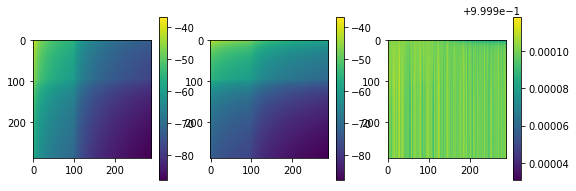

In [103]:
cl22_new = np.load(new_output+'cl22A.npy')
f, ax = plt.subplots(1,3, figsize=(9,3))
im = ax[0].imshow(np.log(cl22_new))
f.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.log(M22A))
f.colorbar(im, ax=ax[1])
im = ax[2].imshow(M22A.T/cl22_new)
f.colorbar(im, ax=ax[2])

print('mean ratio', np.mean(M22A.T/cl22_new))

In [104]:
#getting tilde MA 31a
# script: clphiphi_VB_parallel.py
clphiphi   = np.load('../G_matrices/clphiphi_parallel_%s.npy'%file_ext2)

cl_phiphi_diag= np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    cl_phiphi_diag[:,ii]=clphiphi[:,ii,ii]

clphiphi_diag=[]
from scipy.interpolate import interp1d
for ii in range(len(ell_)):
    clphiphi_diag+=[interp1d(chimax*t_,cl_phiphi_diag[ii])]
#transpose of code
try:
    _, M31aA = np.load('../M_matrices/M31aA_%s.npy'%file_ext)
    M31aA_spline = RectBivariateSpline(ell_,ell_,M31aA)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (galax_kernel(r2d*chimax)*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (lensing_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*(1.+z_chi(r2d*t2d*chimax)))
        chi2fac01 = (lensing_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*(1.+z_chi(r2d/t2d*chimax)))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M31aA = chimax * result*1./np.pi**2/2.*prefac/4./2.

    np.save('../M_matrices/M31aA_%s.npy'%file_ext,[np.meshgrid(ell_),M31aA.T])

    M31aA_spline = RectBivariateSpline(ell_,ell_,M31aA.T)
    M31aA = M31aA.T

mean ratio 0.9992403652980152


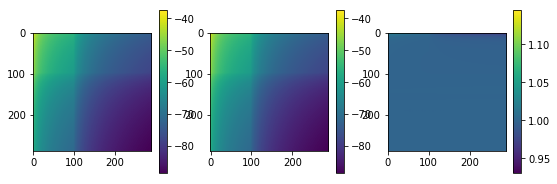

In [106]:
cl31aA_new = np.load(new_output+'cl31aA.npy')
f, ax = plt.subplots(1,3, figsize=(9,3))
im = ax[0].imshow(np.log(M31aA))
f.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.log(M31aA))
f.colorbar(im, ax=ax[1])
im = ax[2].imshow(M31aA/cl31aA_new)
f.colorbar(im, ax=ax[2])

print('mean ratio', np.mean(M31aA/cl31aA_new))

In [107]:
#getting tilde MA2 (Eq.4.5)
try:
    _, M13a = np.load('../M_matrices/M13a_%s.npy'%file_ext)
    M13a_spline = RectBivariateSpline(ell_,ell_,M13a)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (lensing_kernel(r2d*chimax)*(1+z_chi(r2d*chimax))*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (galax_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
        chi2fac01 = (galax_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M13a = chimax * result*1./np.pi**2/2.*prefac/4./2.

    np.save('../M_matrices/M13a_%s.npy'%file_ext,[np.meshgrid(ell_),M13a.T])
    
    M13a_spline = RectBivariateSpline(ell_,ell_,M13a.T)
    M13a = M13a.T

mean ratio 1.0007998898562673


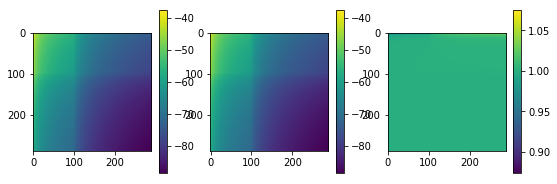

In [110]:
cl13a_new = np.load(new_output+'cl13a.npy')
f, ax = plt.subplots(1,3, figsize=(9,3))
im = ax[0].imshow(np.log(M13a))
f.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.log(M13a))
f.colorbar(im, ax=ax[1])
im = ax[2].imshow(M13a/cl13a_new)
f.colorbar(im, ax=ax[2])

print('mean ratio', np.mean(M13a/cl13a_new))

In [111]:
#adding M13A and M31Aa
tildeMA        = M13a+M31aA
tildeMA_spline = RectBivariateSpline(ell_,ell_,tildeMA)

In [112]:
# sampling for integrations
#31 term only
def get_31_term_only(L,L1,M):
    return -L**4/np.pi*simps(M(L,L1)*L1**3,L1)/4.

In [113]:
phi       = np.linspace(0.,2.*np.pi,1000,endpoint=True)
L1        = np.logspace(np.log(2),3,400)
term31    = get_31_term_only(L1=l,L=L, M=tildeMA_spline)

### ell integrals

In [114]:
def get_regularized_sum_of_terms(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2+2.*LL1/LL*nu)
            integrand = LL1*(LL**2+LL*LL1*nu)*(LL1**2+LL*LL1*nu)**2*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand =  LL1*((LL**2+LL*LL1*nu)*(LL1**2+LL*LL1*nu)**2-LL**2*(LL*LL1*nu)**2)*(M(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

In [115]:
# use same sampling as in Limber case

# sampling for integrations
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)

In [116]:
MA_spline       = M22A_spline
tildeMA_spline  = tildeMA_spline
try:
    L,term1 = np.load('../output/results/term1_%s.npy'%file_ext)
except:
    begin = time.time()
    term1 = get_regularized_sum_of_terms(L,l,phi,MA_spline,tildeMA_spline,method='trapz')+get_second_sum_of_terms(L,l,phi,tildeMA_spline,method='trapz')
    print(time.time()-begin)

    np.save('../output/results/term1_%s'%file_ext,[L,term1])

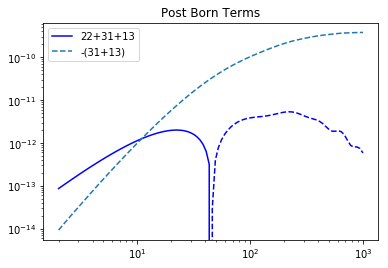

In [117]:
plt.figure()
plt.title('Post Born Terms')
plt.loglog(L,term1,label='22+31+13',color='b')
plt.loglog(L,-term1,color='b',ls='--')
plt.plot(L,-term31, ls='--' ,label='-(31+13)')
plt.legend()

### additional terms that are zero in Limber

In [118]:
# clphipsi code
try:
    Cl = np.load('../G_matrices/clphipsi_%s.npy'%file_ext)
except:
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi) * (xmax > xi)
    chi2_max = chimax
    chi1_max = chimax

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    # inflate by one dimensions (nu_n)
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    Cl = np.zeros((len(t_),len(ell_),len(t_)))

    begin=time.time()

    for jj, chi1_max in enumerate((t_*chimax)):
        if jj%10==0:
            print(jj)

        #psi goes with chi2
        chi1fac0 = (D_chi(r2d*chi2_max)*(1.+z_chi(r2d*chi2_max)))
        chi1fac0 = chi1fac0 *(r2d*chi2_max)**(1-nu_n_.reshape(1, 1, -1))

        # no lensing kernel, because no lensing integration of chi_2
        chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*inner_kernel(r2d*t2d*chi2_max, chi1_max))

        chi2fac01 = (D_chi(r2d*1./t2d*chi2_max)*(1+z_chi(r2d*1./t2d*chi2_max))*inner_kernel(r2d*1./t2d*chi2_max, chi1_max))

        chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w12*chi1fac0* chi2fac0

        result = np.zeros((len(ell_),len(t_)))
        lmax   = ell_.size
        for ii  in range(ell_.size):        
            result[ii] = np.sum(chifacs*I0_ltrc[ii], axis=(0,2)) #not summing over r

        #jj is chi1 -> phi
        Cl[jj] = result*1./np.pi**2/2.*prefac**2 #divide by two for Gauss quad and times two for phi cancel
    # swap axes to have cl_phipsi_l(chi_max,chi)
    Cl = np.swapaxes(Cl,0,1)
    print('Time taken = ', time.time()-begin)

    # first axis ell, second phi, third psi
    np.save('../G_matrices/clphipsi_%s'%file_ext,Cl)
    
clphipsi = np.swapaxes(Cl,1,2)

In [119]:
# clphidelta
try:
    cldeltaphi = np.load('../G_matrices/clphidelta_%s.npy'%file_ext)
except:
    
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi) * (xmax > xi)

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    chimax2   = chimax

    n = 2

    Cl = np.zeros((len(t_),len(ell_),len(t_)))

    begin=time.time()

    for jj, chimax1 in enumerate((t_*chimax)):
        if jj%10==0:
            print(jj)

        chi1fac0  = D_chi(r2d*chimax2)
        chi1fac0  = chi1fac0 *(r2d*chimax2)**(1-(n+nu_n_).reshape(1, 1, -1))

        chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*inner_kernel(r2d*t2d*chi2_max, chimax1))

        chi2fac01 = (inner_kernel(1./t2d*r2d*chimax2,chimax1)*D_chi(r2d*1./t2d*chimax2)*(1+z_chi(r2d*1./t2d*chimax2)))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w12*chi1fac0* chi2fac0

        result    = np.zeros((len(ell_),len(t_)))
        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[ii] = np.sum(chifacs*I2_ltrc[ii],axis=(0,2))

        Cl[jj] = result*1./np.pi**2/2.*prefac/2.*2

    cldeltaphi = np.swapaxes(Cl,0,1)
    print('Time taken = ', time.time()-begin)


    # first axis ell, second phi, third delta
    np.save('../G_matrices/clphidelta_%s'%file_ext,cldeltaphi)

In [120]:
try:
    _ ,M22B = np.load('../M_matrices/M22B_%s.npy'%str(file_ext))
except:
    kernel1 = galax_kernel
    kernel2 = lensing_kernel

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            result[ii][jj] = np.sum(w11*w12*chimax**2*kernel1(r2d*chimax)*kernel2(t2d*chimax)*cldeltaphi[ii]*clphipsi[jj])/4.

    M22B = result

    # first index is L-l, second index is l
    np.save('../M_matrices/M22B_%s.npy'%str(file_ext),[np.meshgrid(ell_),M22B])

M22B_spline = RectBivariateSpline(ell_,ell_,M22B)

mean ratio 1.000000097750879


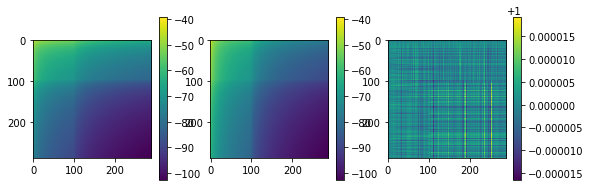

In [125]:
cl22_new = np.load(new_output+'cl22B.npy')
f, ax = plt.subplots(1,3, figsize=(9,3))
im = ax[0].imshow(np.log(cl22_new))
f.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.log(M22B))
f.colorbar(im, ax=ax[1])
im = ax[2].imshow(M22B.T/cl22_new)
f.colorbar(im, ax=ax[2])

print('mean ratio', np.mean(M22B.T/cl22_new))

In [126]:
#this is the term which seems to be absent in the auto
clphipsi_diag = np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    clphipsi_diag[:,ii]=clphipsi[:,ii,ii]

clphipsi_diag_blown=np.zeros((len(ell_),len(t_),len(t_)))
for ii in range(len(t_)):
    clphipsi_diag_blown[:,ii]=clphipsi_diag

try:
    _ , M31aB = np.load('../M_matrices/M31aB_%s.npy'%file_ext)
except:
    cldeltaphi=cldeltaphi.swapaxes(1,2)

    kernel1 = galax_kernel
    kernel2 = lensing_kernel

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            result[ii][jj] = np.sum(w11*w12*kernel1(t2d*chimax)*kernel2(r2d*chimax)*clphipsi_diag_blown[jj]*cldeltaphi[ii])
    result*=chimax**2/4.

    M31aB = result

    # first index is L
    np.save('../M_matrices/M31aB_%s.npy'%file_ext,[np.meshgrid(ell_),M31aB])

M31aB_spline = RectBivariateSpline(ell_,ell_,M31aB)

mean ratio 0.9999999672745524


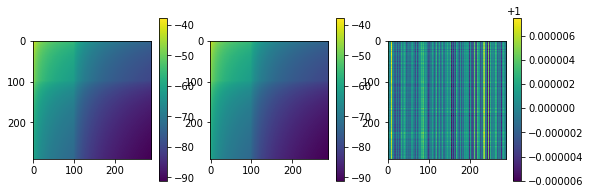

In [127]:
cl31aB_new = np.load(new_output+'cl31aB.npy')
f, ax = plt.subplots(1,3, figsize=(9,3))
im = ax[0].imshow(np.log(M31aB))
f.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.log(M31aB))
f.colorbar(im, ax=ax[1])
im = ax[2].imshow(M31aB/cl31aB_new)
f.colorbar(im, ax=ax[2])

print('mean ratio', np.mean(M31aB/cl31aB_new))

In [128]:
def get_regularized_sum_of_terms_2(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = -LL*LL1*nu*(LL*LL1*nu-LL1**2)**2*LL1*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms_2(L,L1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand =  LL1*(((LL*LL1*nu)**2*LL1**2)-LL*LL1*nu*(LL*LL1*nu-LL1**2)**2)*(M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


In [129]:
try:
    L, term2 = np.load('../output/results/term2_%s.npy'%file_ext)
except:    
    term2 = get_regularized_sum_of_terms_2(L,l,phi,M22B_spline,M31aB_spline,method='trapz')+get_second_sum_of_terms_2(L,l,M31aB_spline,method='trapz')
    np.save('../output/results/term2_%s'%file_ext,[L,term2])

In [145]:

'../G_matrices/clphigal_%s.npy'%file_ext

'../G_matrices/clphigal_lsstall_cmblens_simple_bias_zmax10886.npy'

In [130]:
chimaxs = np.load('../G_matrices/clphigalchimaxs_%s.npy'%file_ext)
clgphi  = np.load('../G_matrices/clphigal_%s.npy'%file_ext)
#check if chimaxs are in correct order

r2d, t2d = np.meshgrid(t_,t_)
np.prod((chimaxs==r2d*t2d*chimax))

try:
    _, M31b = np.load('../M_matrices/M31b_%s.npy'%str(file_ext))
except:
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi)*(xmax > xi)
    
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    clgphi_  = np.expand_dims(clgphi,-1)


    result   = np.zeros((len(ell_),len(ell_)))

    n = 0

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = (lensing_kernel(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = inner_kernel(r2d*t2d*chimax,chimax*r2d)*D_chi(r2d*t2d*chimax)*(1.+z_chi(r2d*t2d*chimax))*clgphi_[nn]

        chi2fac0  = chi2fac00

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I0_ltrc[ii])

    print(time.time()-begin)

    #- sign from going clphidelta
    M31b = -chimax*result*1./np.pi**2/2.*prefac**2/4.*2

    #first index L, second index l
    np.save('../M_matrices/M31b_%s.npy'%str(file_ext),[np.meshgrid(ell_),M31b])
M31b_spline = RectBivariateSpline(ell_,ell_,M31b)
# to do: check if l grids are correct

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
353.1311454772949


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


1.0000000960631978
1.0000000192511656
1.0000000261199349
0.9999999840876942


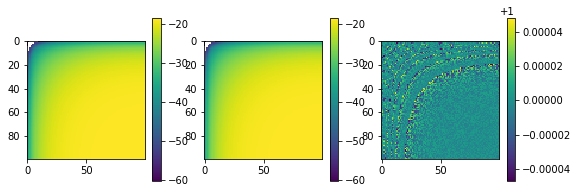

In [143]:
clgphi_Chirag = np.load('/global/homes/v/vboehm/codes/postborn-corrections/scripts/meshes/output/cmb/clphideltacmb-lsst-all-simple.npy')
f, ax = plt.subplots(1,3, figsize=(9,3))
im = ax[0].imshow(np.log(clgphi_Chirag[10]))
f.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.log(clgphi[10]))
f.colorbar(im, ax=ax[1])
im = ax[2].imshow(clgphi[10]/clgphi_Chirag[10])
f.colorbar(im, ax=ax[2])
for ii in [0,10,100,280]:
    print(np.mean(clgphi[ii]/clgphi_Chirag[ii]))

mean ratio -0.9999999949568569


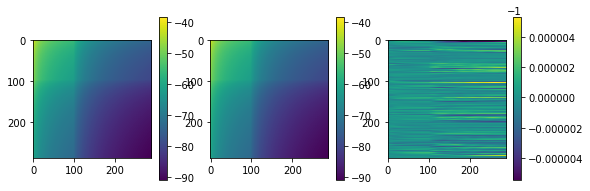

In [144]:
cl31b_new = np.load(new_output+'cl31b.npy')
f, ax = plt.subplots(1,3, figsize=(9,3))
im = ax[0].imshow(np.log(cl31b_new))
f.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.log(-M31b))
f.colorbar(im, ax=ax[1])
im = ax[2].imshow(M31b/cl31b_new)
f.colorbar(im, ax=ax[2])

print('mean ratio', np.mean(M31b/cl31b_new))

In [146]:
# Eq. 5.6
def l_integration_1(M,L,l):
    return L**2*np.trapz(l**5*M(L,l),l)/4./np.pi


In [147]:
res=[]
for LL in L:
    res+=[l_integration_1(M31b_spline,LL,l)]
res = np.asarray(res)
res = res[:,0]
np.save('../output/results/term3_%s.npy'%file_ext,[L,res])
term31b = res


Term 2:
$-2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 L^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') \int_0^{\chi'} \mathrm{d}\chi'' W(\chi'',\chi') C_L^{\psi\psi}(\chi'',\chi)   C_l^{\delta\phi}(\chi',\chi'')\\
= -2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 L^2 \int \mathrm{d}\chi'  W^h(\chi') \int_0^{\chi'} \mathrm{d}\chi'' W(\chi'',\chi') C_L^{\psi\phi}(\chi'')   C_l^{\delta_h \phi}(\chi',\chi'') $

In [154]:
#phi goes up to chi''
clphidelta  = np.load('../G_matrices/clphidelta_parallel_MB2_%s.npy'%file_ext2)


#phi goes to chi_source
clphipsi    = np.load('../G_matrices/clpsiphi_parallel_MB2_%s.npy'%file_ext2)

print(clphidelta.shape)
print(clphipsi.shape)

try:
    _, M13b = np.load('../M_matrices/M13b_%s.npy'%str(file_ext))
    M13b_spline = RectBivariateSpline(ell_,ell_,M13b)
except:
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi)*(xmax > xi)

    kernel2 = inner_kernel
    kernel1 = galax_kernel

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)


    result   = np.zeros((len(ell_),len(ell_)))

    n = 0

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = kernel1(r2d*chimax)
        chi1fac0 = chi1fac0*(r2d*chimax)

        chi2fac0 = kernel2(r2d*t2d*chimax,chimax*r2d)*clphipsi[nn]
        chifacs  = w11*w12*chi1fac0*chi2fac0

        for ii  in range(len(ell_)):        
            result[nn][ii] = np.sum(chifacs*clphidelta[ii])

    #first index is L
    M13b = chimax*result/4./2.

    np.save('../M_matrices/M13b_%s.npy'%str(file_ext),[np.meshgrid(ell_),M13b])
    M13b_spline = RectBivariateSpline(ell_,ell_,M13b)

(289, 100, 100)
(289, 100, 100)
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


mean ratio 1.2347573913760437


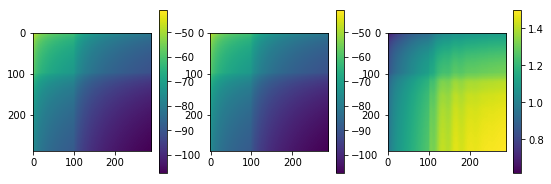

In [155]:
cl13b_new = np.load(new_output+'cl13b.npy')
f, ax = plt.subplots(1,3, figsize=(9,3))
im = ax[0].imshow(np.log(M13b))
f.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.log(M13b))
f.colorbar(im, ax=ax[1])
im = ax[2].imshow(M13b/cl13b_new)
f.colorbar(im, ax=ax[2])

print('mean ratio', np.mean(M13b/cl13b_new))

In [156]:
#all minus signs cancel
def l_integration_2(M,L,l):
    return L**4*np.trapz(l**3*M(L,l),l)/4./np.pi #2 went into clphipsi

In [157]:
res=[]
for LL in L:
    res+=[l_integration_2(M13b_spline,LL,l)]
res = np.asarray(res)
res = res[:,0]
np.save('../output/results/term4_%s.npy'%file_ext,[L,res])
term13b = res

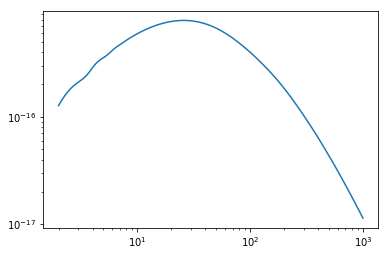

In [158]:
plt.loglog(L,res)

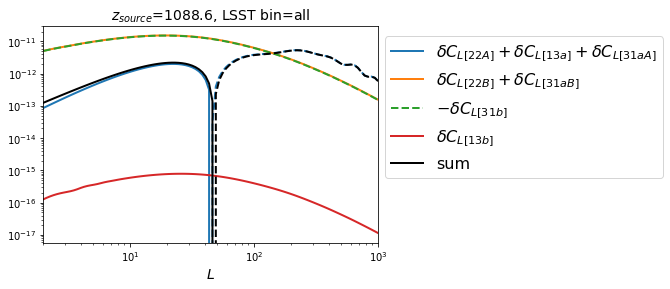

In [162]:
plt.figure()
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=14)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=14)  
#plt.title('Post Born terms (without Jacobian)',fontsize=14)
p=plt.loglog(L,term1,label='$\delta C_{L[22A]}+\delta C_{L[13a]}+\delta C_{L[31aA]}$',lw=2)
plt.loglog(L,-term1,ls='--',c=p[0].get_color(),lw=2)
p=plt.loglog(L,term2,label='$\delta C_{L[22B]}+\delta C_{L[31aB]}$',lw=2)
plt.loglog(L,-term2,ls='--',c=p[0].get_color(),lw=2)
plt.loglog(L,-term31b,label='$-\delta C_{L[31b]}$',ls='--',lw=2)
plt.loglog(L,term13b,label='$\delta C_{L[13b]}$',ls='-',lw=2)
plt.loglog(L,term1+term2+term31b+term13b,ls='-',c='k',lw=2,label='sum')
plt.loglog(L,-(term1+term2+term31b+term13b),ls='--',c='k',lw=2)
plt.legend(loc=(1.02,0.3),fontsize=16)
plt.xlabel('$L$',fontsize=14)
plt.xlim(min(L),max(L))
plt.savefig(plotpath+'postbornterms_%s.png'%file_ext, bbox_inches='tight',dpi=400)

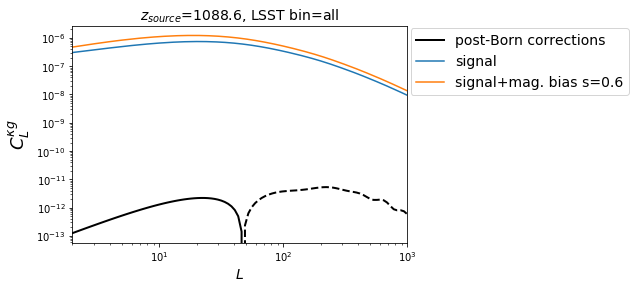

In [163]:
s=0.6
corr_signal=(J11bare*5.*(s-0.4)+Cl_kg)
plt.figure()
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=14)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=14)  
plt.loglog(L,term1+term2+term31b+term13b,ls='-',c='k',lw=2,label='post-Born corrections')
plt.loglog(L,-(term1+term2+term31b+term13b),ls='--',c='k',lw=2)
#plt.loglog(L,-term31,ls='--',lw=1,label='$\delta C_{L[13a]}+\delta C_{L[31aA]}$')
plt.plot(ell_,Cl_kg,label='signal')
plt.plot(ell_,corr_signal,label='signal+mag. bias s=0.6')
plt.legend(fontsize=14,loc=(1.01,0.68))
plt.xlim(min(L), max(L))
plt.xlabel('$L$',fontsize=14)
plt.ylabel('$C_L^{\kappa g}$',fontsize=18)
plt.savefig(plotpath+'signal_vs_corrections_%s.png'%file_ext, bbox_inches='tight',dpi=400)

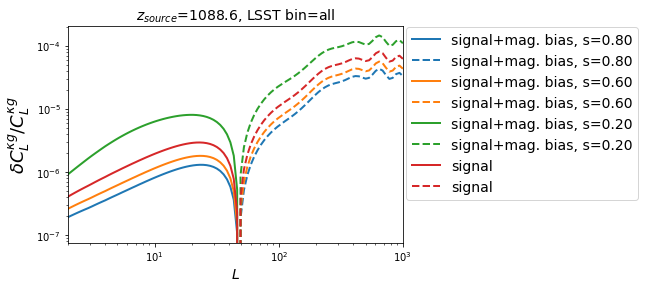

In [170]:
plt.figure()
if LSST:
    plt.title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=14)
else:
    plt.title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=14)  
for s in [0.8,0.6,0.2]:
    corr_signal=(J11bare*5.*(s-0.4)+Cl_kg)
    p= plt.loglog(L,(term1+term2+term31b+term13b)/np.interp(L,ell_,corr_signal),lw=2,label='signal+mag. bias, s=%.2f'%s)
    plt.loglog(L,-(term1+term2+term31b+term13b)/np.interp(L,ell_,corr_signal),lw=2,ls='--',color=p[0].get_color(),label='signal+mag. bias, s=%.2f'%s)
p= plt.loglog(L,(term1+term2+term31b+term13b)/np.interp(L,ell_,Cl_kg),lw=2,label='signal')
p= plt.loglog(L,-(term1+term2+term31b+term13b)/np.interp(L,ell_,Cl_kg),ls='--', color=p[0].get_color(),lw=2,label='signal')


plt.legend(fontsize=14,loc=((1.01,0.2)))
plt.xlim(min(L), max(L))
plt.xlabel('$L$',fontsize=14)
plt.ylabel('$\delta C_L^{\kappa g}/C_L^{\kappa g}$',fontsize=18)
plt.savefig(plotpath+'signal_vs_corrections_%s_relative.png'%file_ext, bbox_inches='tight',dpi=400)

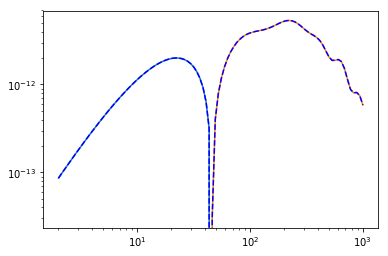

In [190]:
term1_new = np.loadtxt(new_output+'cl2213limber.txt')
L1        = term1_new[0]
term1_new = term1_new[1]+term1_new[2]

plt.figure()
plt.loglog(L1,term1_new)
plt.loglog(L1,-term1_new)
plt.loglog(L,term1, ls='--',c='b')
plt.loglog(L,-term1, ls='--', c='b')

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


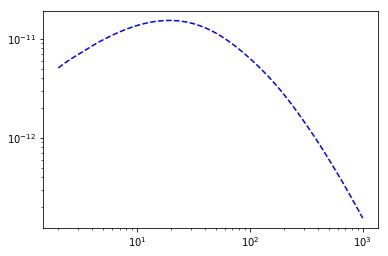

In [192]:
term2_new = np.loadtxt(new_output+'cl2213postlimber.txt')
L1        = term2_new[0]
term2_new = term2_new[1]+term2_new[2]

plt.figure()
plt.loglog(L1,term2_new)
#plt.loglog(L1,-term2_new)
plt.loglog(L,term2, ls='--',c='b')
#plt.loglog(L,-term2, ls='--', c='b')